# Random processes and Monte Carlo methods

<a href="https://www.youtube.com/watch?v=Dcz2JdrhpwQ" target="_blank"><img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/cms-event.png"  /></a>



## PHYS 2600: Scientific Computing

## Lecture 19

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## FAQ: += versus + in NumPy
An interesting question came up in the last, for the `step_random_walk` function:

In [2]:
def step_random_walk_2d(x_coords, y_coords):

    phi = np.random.rand(len(x_coords)) * 2 * np.pi
    x_coords += np.cos(phi)
    y_coords += np.sin(phi)

    # Return None (since we changed the arrays in-place)
    return None

This works as expected if we update the coordinates using `+=`. Several of you tried re-assigning with `+`, and ran into problems with code like this:

In [3]:
def step_random_walk_2d(x_coords, y_coords):

    phi = np.random.rand(len(x_coords)) * 2 * np.pi
    x_coords = x_coords + np.cos(phi)
    y_coords = y_coords + np.sin(phi)

    # Return None (since we changed the arrays in-place)
    return None

Why do these not work the same way? It turns out that in NumPy, `+=` does in-memory changes, while `+` returns a new array at a new location in memory. To see this, look at these examples: 

In [4]:
a = np.array([1, 1, 1])
b = a
b += np.array([6, 7, 8])
print(a is b, a, b)

True [7 8 9] [7 8 9]


In [5]:
a = np.array([1, 1, 1])
b = a
b = b + np.array([6, 7, 8])
print(a is b, a, b)

False [1 1 1] [7 8 9]


In both examples, the code `b=a` makes a name `b` that points to the same array in the same memory location as `a`. When we update `b` with `+=`, the array in that memory location is updated. However, when we update `b` with `+`, a new array in a new memory location is created, with the name `b` pointing to it.

The moral of the story is: when updating in place, best to use `+=`.

## FAQ: Function Headers and Local Scope

When we define a function, we give it a set of parameters that we want to use in the function. The parameters are in the local scope of the function, which means that variable can only be used inside the function. A function can use variables in the scope that contains it.

In [6]:
def myFunc(arg):
    def nestFunc():
        nestVar = arg
        print(f"This code is inside nestFunc: nestVar = {nestVar}")

    nestFunc()
    return nestVar


# print(myFunc("This is my input."))

In [7]:
x = np.linspace(0, 11, 11)
print(x)
y = np.ones(11) * 3

area = np.trapezoid(y, x)
print(area)

[ 0.   1.1  2.2  3.3  4.4  5.5  6.6  7.7  8.8  9.9 11. ]
33.0


## Monte Carlo method

The __Monte Carlo method__ is an extremely powerful technique for solving computational science problems.  The precise definition varies, but I would define it like this:

1. Choose some _random inputs_ for a problem.
2. For each input, solve the problem to get a distribution of _random outputs_.
3. Use statistics on the outputs to make _deterministic_ statements about the problem.

<img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/LosAlamos.jpg" width=400px style="float:right;" />

Monte Carlo simulation can: 
* Simulate problems in statistical physics
* Propagate uncertainty through very complex problems
* Solve optimization problems
* Do integrals efficiently.

The original formulation of Monte Carlo (and the name) came from physicist Stanislaw Ulam (right: Von Neumann, Feynman, and Ulam), working on the Manhattan Project and trying to understand neutron reactions.  [Here's a nice write-up from the Los Alamos archives](https://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-UR-88-9067), if you're curious.

Understanding the physics of particle colliders is a great example of Monte Carlo methods in action!  The sequence of events in a collision at the Large Hadron Collider is:

1. Two protons collide, releasing an enormous amount of energy which is converted into new particles via $E = mc^2$. 
2. The new particles fly outward, many of them decay into even more daughter particles or emit radiation.
3. After a little while, the particles start to reach the detectors and interact with them, depositing energy and momentum.




<img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/cms-higgs.png" width=400px style="float:left;margin:10px;" />

Any one of those things happening in isolation can be understood with pen and paper - but combining them all together is incredibly difficult!  With Monte Carlo simulation, we compute probabilities _in isolation_, then draw random numbers to produce chains of events from start to finish.

The Higgs boson discovery (left) relied on Monte Carlo simulation to calibrate the "background" of not-Higgs events contaminating the search.

## Numerical Probability

To understand Monte Carlo methods, we have to start with numerical approaches to probability - going back to the discrete versions, which means __counting__.

<img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/red-blue-bag.png" width=300px style="float:right;" />

Suppose we have $N_R$ red balls and $N_B$ blue balls in a bag.  The probability of drawing a red ball at random is just

$$
p(R) = \frac{N_R}{N_R + N_B}
$$

If we have three of each, then this is 3/6 = 0.5.  All we had to do is count!



<img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/red-blue-bag-2.png" width=300px style="float:right;" />

Okay, now what is $p(R)$ for _this_ bag?  Even with a computer, exhaustive counting of every possible outcome is usually not practical!

This leads to the idea of __sampling__.  From a bag of any size, we draw a small number $n$ (the _sample size_), and then just count within the sample:

$$
p_n(R) = \frac{n_r}{n_r + n_b}
$$

As we take larger and larger samples, we approach the true "population probability" $p(R)$ that we'd get from counting everything exhaustively.  

In fact, we can do this experiment numerically: if we set up a list of 20,000 balls, some red and some blue, then we can __simulate__ the results of physically drawing balls using an RNG.

p_R exact = 0.54135
['B' 'R']
0.495


<BarContainer object of 2 artists>

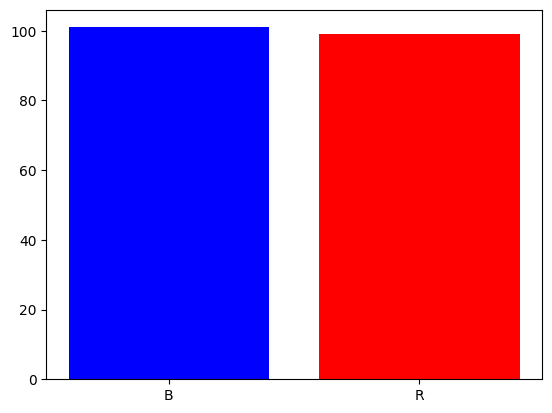

In [8]:
my_bag = ["B"] * 9173 + ["R"] * 10827  # 20k total
print(f"p_R exact = {10827 / 20000}")
sample = np.random.choice(my_bag, size=200)  # sample size 200
colors, (N_blue, N_red) = np.unique(sample, return_counts=True)
print(colors)
print(N_red / (N_blue + N_red))
plt.bar(colors, (N_blue, N_red), color=["blue", "red"])

The exact probability $p(R)$ is `10827/20000 = 0.54135` - the outcome of the experiment above fluctuates around that value.

Although we know that "large enough" $n$ will allow us to get "close enough" to the true distribution, we can't know _how_ far off we are in the outcome of a single sample.  When we have a simulation, we can be good scientists and repeat the experiment!

Keeping sample size $n$ fixed, we can conduct multiple __trials__ $T$ where we repeat the random simulation.  The fluctuations over many trials has extra information that we can make use of.

Let's try this out with our red/blue ball experiment:

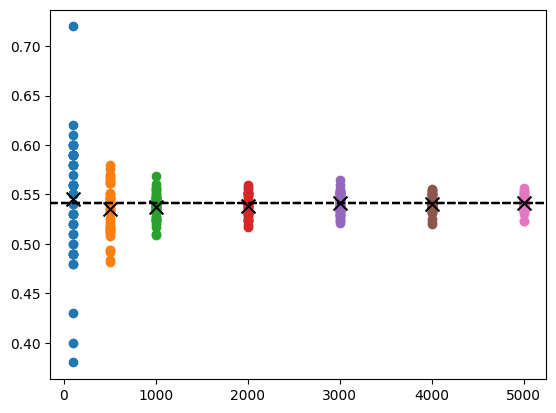

In [9]:
def pR_sample(sample_size, trials=50):
    pR_list = []
    for _ in range(trials):
        sample = np.random.choice(my_bag, size=sample_size)
        pR = len(sample[sample == "R"]) / sample_size
        pR_list.append((sample_size, pR))

    return np.array(pR_list)


# Try 50 trials of different sample sizes
for ss in (100, 500, 1000, 2000, 3000, 4000, 5000):
    pR_list = pR_sample(ss)
    plt.scatter(pR_list[:, 0], pR_list[:, 1])
    plt.scatter(pR_list[0, 0], np.mean(pR_list[:, 1]), color="k", marker="x", s=100)
    plt.axhline(10827 / 20000, ls="--", color="k")

We see two features from our experiment.  
1. For any sample size the _average over many trials_ of $p_n(R)$ (denoted by the X) is close to the true probability $p(R)$.
1. The fluctuations of the $p_n(R)$ away from $p(R)$ are smaller as $n$ increases.

These are both consequences of a very powerful result in statistics, the __central limit theorem__.  The central limit theorem says that if we look at the distribution of sample means $\mu_n$ _over many trials_, that distribution is normal (Gaussian) of the form

$$
\mu_n -\mu \sim \mathcal{N}\left(0, \frac{\sigma^2}{n} \right)
$$

where $\sigma^2$ is the true variance of whatever we're sampling from. 

To restate the math in words, the central limit theorem tells us two things about the distribution of sample means $\mu_n$:

1. The mean is zero, i.e. the difference between $\mu_n$ and $\mu$ is zero on average;
1. The variance _shrinks proportional to $1/n$_, which means that the larger we make $n$, the smaller the fluctuations of $\mu_n$ around the true mean $\mu$ will be.

We can exploit the fact that the variance shrinks in this specific way to answer the question, if we just draw one random sample, how close is $\mu_n$ to the right answer $\mu$ on average?  This is quantified by the __standard error of the mean__,

$$
\sigma_{\rm{SEM}} = \frac{1}{\sqrt{n}} \sigma_n
$$
where $\sigma_n$ is the sample standard deviation.  Thanks to the central limit theorem, we know that $\mu_n$ is within $\sigma_{\rm{SEM}}$ of $\mu$ in 68% of trials, $2\sigma_{\rm{SEM}}$ in 95% of trials, etc.

To recap: we draw a sample $S_n$ from an underlying _true distribution_.  As the size of the sample approaches infinity, __the sample distribution approaches the true distribution__ (under some basic assumptions, like the samples being independent of each other.)

On the other hand, at a _fixed sample size_ $n$, we can imagine __repeating the experiment $T$ times__, getting many samples $S_{n,0}, S_{n,1}, ..., S_{n,T-1}$.  Then if we look at the means $\{\mu_{n,i}\}$ all together, the central limit theorem tells us they will be distributed normally, and the width of the distribution is given by the standard error.

<img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/two-dists.png" width=550px />

In normal circumstances, we run our experiments once and live with finite sample size $n$; the results above come for things like $\sigma_{\rm{SEM}}$ come from theory.  In this case, __Monte Carlo simulation gives us direct access to the distribution over many trials__, letting us check some of these statistical insights!

More generally, Monte Carlo simulation is a straightforward way to deal with much more complicated questions.

To extend the red/blue ball example: what if we wanted to know the probability of drawing exactly 7 red balls out of 19 draws?  And the error on this prediction over many trials?  More complicated to predict, but easy to simulate!

Adding more steps is easy, too.  Suppose instead of just counting red balls, we play a game where a red ball is +2 points and a blue ball is -1.  What is the optimal number of draws if you want to maximize your score on average?  Again, very easy to simulate (just adding a deterministic score calculation onto our random simulation!)

Any time the individual pieces of some calculation are simple, but the total process from start to finish is too complex - you should consider reaching for Monte Carlo!  (This applies even to problems which are _not_ statistical at all, as we will see next time.)

## Tutorial 19

We're ready for some simple Monte Carlo method practice! Go ahead and load `tut19`.